# TDA de Cambios en Precios y Oferta-Demanda de Productos Perecederos
Author: A. Ramirez-Morales (andres.ramirez@tec.mx)


En este notebook se implementa:
1. Generación avanzada de datos con Monte Carlo
2. Análisis TDA completo (homología persistente + Mapper)
3. Detección de cambios estructurales con ventanas deslizantes y Takens embedding
4. Modelos predictivos híbridos (TDA + ML)

### 1. Importación de librerías

In [3]:
!pip install giotto-tda
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.8/558.8 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.6/460.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not cur

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.mapper import (
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph
)
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import SMOTE
import networkx as nx
np.random.seed(42)
plt.style.use('ggplot')

### 2. Generación de datos

Actividades/preguntas:
1. Definir los siguientes conceptos: producto perecedero, evento de mercado, brokers, estrategia de broker, tipos de estrageias de broker, variables climaticas, estacionalidad, calidad de producto, elasticidad cruzada
2. Comentar (describir) las líneas más importantes y escribir documentación adecuada para la clase `DatosAgricolas`
3. En la clase `DatosAgricolas` hay varios parámetros que usted puede ajustar, identifíquelos e interprete ssu efecto en los datos.
4. Describa el outcome que espera de la clase `DatosAgricolas`
5. Discuta cualesquiera otras informaciones en `DataAgricolas` que puedan ser relevantes.

In [ ]:
class DatosAgricolas:
    """
    Simulación de datos para productos agrícolas perecederos
    con eventos de mercado, comportamientos de brokers y variables climáticas.
    """
    def __init__(self, params, factor=1000, n_dias=1000):
        self.n_dias = n_dias
        self.fechas = pd.date_range(start="2023-01-01", periods=n_dias, freq='D')
        self.df = None
        self.eventos = None
        # frambuesa data
        self.m_precio_frambuesa = params['precio_frambuesa']/factor
        self.m_precio_frambuesa_var = params['precio_frambuesa_var']/factor
        self.m_volumen_frambuesa = params['volumen_frambuesa']/factor
        self.m_volumen_frambuesa_var = params['volumen_frambuesa_var']/factor
        # aguacate data
        self.m_precio_aguacate = params['precio_aguacate']/factor
        self.m_precio_aguacate_var = params['precio_aguacate_var']/factor
        self.m_volumen_aguacate = params['volumen_aguacate']/factor
        self.m_volumen_aguacate_var = params['volumen_aguacate_var']/factor
        # chile seco data
        self.m_precio_chile = params['precio_chile']/factor
        self.m_precio_chile_var = params['precio_chile_var']/factor
        self.m_volumen_chile = params['volumen_chile']/factor
        self.m_volumen_chile_var = params['volumen_chile_var']/factor

    def generar_base(self):
        """
        Genera datos base para los productos
        """
        # precios base con tendencias estacionales
        tiempo = np.linspace(0, 10, self.n_dias)
        estacionalidad = np.sin(2 * np.pi * tiempo / 365) * 0.2
        
        # variables climáticas
        temperatura = 25 + 10 * np.sin(2 * np.pi * tiempo / 365) + np.random.normal(0, 3)
        humedad = 60 + 20 * np.sin(2 * np.pi * tiempo / 365 + np.pi/2) + np.random.normal(0, 5)

        # frambuesa - producto altamente perecedero
        precio_frambuesa = np.exp(np.random.normal(self.m_precio_frambuesa + estacionalidad, self.m_precio_frambuesa_var, size=self.n_dias))
        volumen_frambuesa = np.random.normal(self.m_volumen_frambuesa, self.m_volumen_frambuesa_var, size=self.n_dias) + np.random.normal(0, 50) * estacionalidad
        calidad_frambuesa = np.clip(0.9 - 0.005*(temperatura-25)**2 - 0.002*(humedad-70)**2 + np.random.normal(0, 0.05), 0.5, 1.0)

        # aguacate - menos perecedero
        precio_aguacate = np.exp(np.random.normal(self.m_precio_aguacate + estacionalidad, self.m_precio_aguacate_var, size=self.n_dias))
        volumen_aguacate = np.random.normal(self.m_volumen_aguacate, self.m_volumen_aguacate_var, size=self.n_dias) + np.random.normal(0, 50) * estacionalidad
        calidad_aguacate = np.clip(0.95 - 0.003*(temperatura-22)**2 + np.random.normal(0, 0.03), 0.7, 1.0)

        # chile seco - producto estable
        precio_chile = np.exp(np.random.normal(self.m_precio_chile + estacionalidad, self.m_precio_chile_var, size=self.n_dias))
        volumen_chile = np.random.normal(self.m_volumen_chile, self.m_volumen_chile_var, size=self.n_dias) + np.random.normal(0, 50) * estacionalidad
        calidad_chile = np.clip(0.85 - 0.001*(humedad-50)**2 + np.random.normal(0, 0.04), 0.6, 1.0)

        # datos sin modificaciones de brokers
        datos = {
            'fecha': self.fechas,
            'precio_frambuesa': precio_frambuesa,
            'volumen_frambuesa': volumen_frambuesa,
            'calidad_frambuesa': calidad_frambuesa,
            'precio_aguacate': precio_aguacate,
            'volumen_aguacate': volumen_aguacate,
            'calidad_aguacate': calidad_aguacate,
            'precio_chile': precio_chile,
            'volumen_chile': volumen_chile,
            'calidad_chile': calidad_chile,
            'temperatura': temperatura,
            'humedad': humedad,
            'estacionalidad': estacionalidad,
        }

        return pd.DataFrame(datos)

    def agregar_eventos_mercado(self, df):
        """
        Agrega eventos de mercado simulados
        """
        eventos = np.zeros(self.n_dias)

        # frambuesa (perecedero)
        for i in range(100, self.n_dias, 180):
            duracion = np.random.randint(5, 15)
            intensidad = np.random.uniform(0.4, 0.7)

            df.loc[i:i+duracion, 'precio_frambuesa'] *= intensidad
            df.loc[i:i+duracion, 'volumen_frambuesa'] *= np.random.uniform(1.2, 1.8)
            eventos[i:i+duracion] = 1  # Evento tipo 1: sobreoferta

        # aguacate (especulación)
        for i in range(150, self.n_dias, 220):
            duracion = np.random.randint(10, 20)
            intensidad = np.random.uniform(1.3, 1.8)

            df.loc[i:i+duracion, 'precio_aguacate'] *= intensidad
            df.loc[i:i+duracion, 'volumen_aguacate'] *= np.random.uniform(0.6, 0.9)
            eventos[i:i+duracion] = 2  # Evento tipo 2: especulación

        # climáticos extremos
        for i in range(200, self.n_dias, 300):
            duracion = np.random.randint(7, 14)

            df.loc[i:i+duracion, 'temperatura'] += np.random.uniform(5, 10)
            df.loc[i:i+duracion, 'humedad'] -= np.random.uniform(15, 25)
            eventos[i:i+duracion] = 3  # Evento tipo 3: clima extremo

        return df, eventos

    def simular_comportamiento_brokers(self, df):
        """
        Simula el comportamiento estratégico de brokers
        """
        # estrategias de brokers basadas en condiciones de mercado
        df['estrategia_broker'] = 'neutral'

        # identificar condiciones para diferentes estrategias
        mask_sobreoferta = (df['precio_frambuesa'].pct_change(5) < -0.15)
        mask_especulacion = (df['precio_aguacate'].pct_change(5) > 0.2)
        mask_clima_extremo = (df['temperatura'] > 32) | (df['humedad'] < 40)

        df.loc[mask_sobreoferta, 'estrategia_broker'] = 'liquidacion'
        df.loc[mask_especulacion, 'estrategia_broker'] = 'acaparamiento'
        df.loc[mask_clima_extremo, 'estrategia_broker'] = 'precaucion'

        return df

    def generar_datos(self):
        """
        Genera el conjunto completo de datos simulados
        """
        df = self.generar_base()
        df, eventos = self.agregar_eventos_mercado(df)
        df = self.simular_comportamiento_brokers(df)

        # agregar elasticidad cruzada simulada
        df['precio_fresa'] = df['precio_frambuesa'] * np.random.uniform(0.8, 1.2)
        df.loc[df['precio_frambuesa'] > df['precio_frambuesa'].quantile(0.8), 'precio_fresa'] *= 1.1

        self.df = df
        self.eventos = eventos
        return df, eventos

1.- Producto perecedero: Este es un tipo de bien el cual tiene una vida útil corta y se deteriora rápidamente, llámese frutas, verduras o algún tipo de producto orgánico.
2.- Evento de mercado: Suceso que modifica la oferta y la demanda de un producto, como cambios en el clima, regulaciones gubernamentales, tarifas como las famosas de Trump, entre otros.
3.- Brokers: Es un corredor de bolsa, un intermediario que "facilita" la compra y venta de diversos instrumentos financieros.
4.- Estrategia de broker: Plan de acción que un broker sigue para maximizar sus ganancias y minimizar riesgos en la compra y venta de productos financieros, se especifica lo que adquirirá, como se va a operar y mediante qué reglas se va a guiar; se debe tiamr en cuenta los objetivos, la tolerancia al riesgo de cada cliente, el horizonte de tiempo al que se va a adecuar, el análisis de mercado, selección de activos, etc.
5.- Tipos de estrategias de broker: Hay 5 tipos de estrategias principales, la estrategia de inversión como la inversión de valor, de tendencia, momentum, cuantitativa, entre otras; estrategias de trading como swing trading, day trading (Aunque se necesita de mayor inversión en estas), scalping, posición; estrategia de gestión de riesgos como diversificación, cobertura, parada de pérdidas; selección de activos, mediante análisis fundamenta, técnico, de mercado o volatilidad y por último la de instrumentos financieros como a futuros o CFDs (Contratos por diferencia).
6.- Variables climáticas: Factores ambientales que afectan la producción y calidad de los productos perecederos a analizar como temperatura, humedad, precipitaciones, etc.
7.- Estacionalidad: Variaciones en la oferta y demanda de productos perecederos a lo largo del año, influenciadas por factores climáticos y/o culturales, como el aumento de aguacate por el superbowl.
8.- Calidad de producto: Características que determinan la frescura y valor de los producto perecedero a analizar, como apariencia, sabor, textura, etc.
9.- Elasticidad cruzada: Primero debemos de saber lo que es la elasticidad; la elasticidad mide qué tanto se ve afectado un producto de acuerdo a la variación en los precios, nos permite entender la sensibilidad de ese bien respecto al precio, por lo tanto la elasticidad cruzada es una medida de cómo la cantidad demandada de un producto cambia en respuesta a cambios en el precio de otro producto relacionado con el mismo.

### 2.1 Genear y visualizar datos

Actividades/preguntas:
1. Genere los datos y guardélos en una base de datos con formato csv.
2. Grafique los datos más relevantes a su consideración.
3. Juegue con los parámetros que considere mas relvantes dentro de la clase `DatosAgricolas`
4. Dé una interpretación


In [59]:
# generamos los datos solo para frambuesa
params = {
    'precio_frambuesa': 13471,
    'precio_frambuesa_var': 6.6,
    'volumen_frambuesa': 190412,
    'volumen_frambuesa_var': 6.9,

    'precio_aguacate': 1,
    'precio_aguacate_var': 1,
    'volumen_aguacate': 1,
    'volumen_aguacate_var': 1,
    'precio_chile': 1,
    'precio_chile_var': 11,
    'volumen_chile': 1,
    'volumen_chile_var': 1,
    
}

# instanciamos la clase
datos_agricolas = DatosAgricolas(params, factor=1000, n_dias=1000)
# generamos los datos
df, eventos = datos_agricolas.generar_datos()
# convertimos la fecha a datetime
df['fecha'] = pd.to_datetime(df['fecha'])

# mostramos los primeros 5 registros
df.head()


,fecha,precio_frambuesa,volumen_frambuesa,calidad_frambuesa,precio_aguacate,volumen_aguacate,calidad_aguacate,precio_chile,volumen_chile,calidad_chile,temperatura,humedad,estacionalidad,estrategia_broker,precio_fresa
0,2023-01-01,705977.450447,190.408694,0.808088,1.001938,0.001753,0.910467,1.007860,0.002682,0.6,24.449327,77.281884,0.000000,neutral,804730.031833
1,2023-01-02,706285.683854,190.416628,0.808098,1.001866,0.001947,0.910441,1.000098,0.002630,0.6,24.451050,77.281883,0.000034,neutral,805081.381128
2,2023-01-03,706771.845531,190.410534,0.808107,1.000768,0.002550,0.910416,0.998210,0.002969,0.6,24.452773,77.281882,0.000069,neutral,805635.547413
3,2023-01-04,703676.269728,190.416470,0.808117,1.000808,0.005977,0.910391,0.985404,0.004487,0.6,24.454497,77.281881,0.000103,neutral,802106.960470
4,2023-01-05,727219.732946,190.410960,0.808126,1.001968,0.003412,0.910365,0.994599,0.004249,0.6,24.456220,77.281879,0.000138,neutral,911838.068369


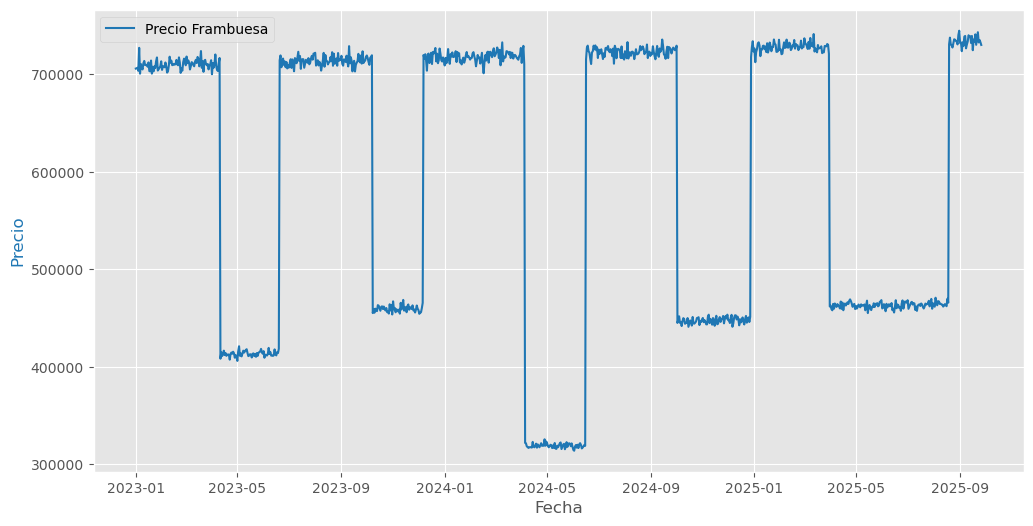

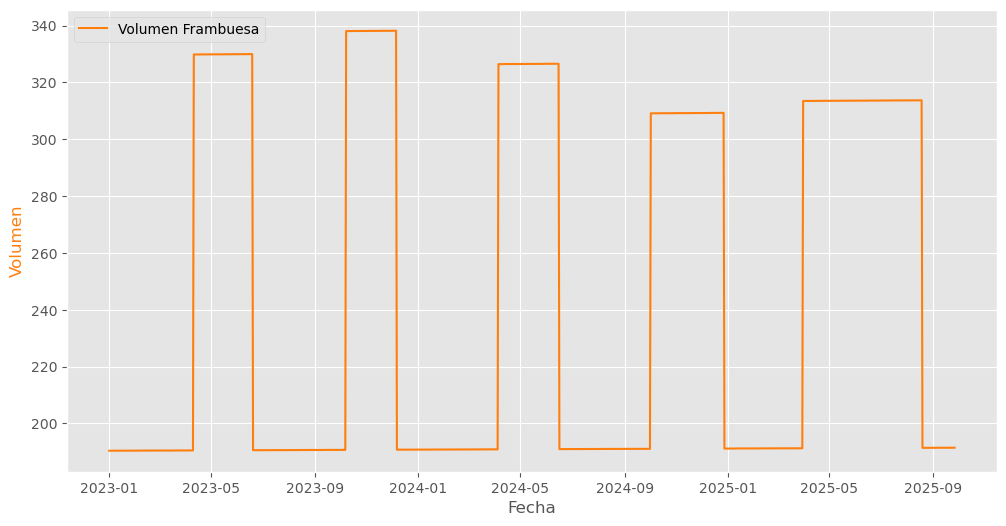

In [60]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio del volumen total')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio', color='tab:blue')
ax1.plot(df['fecha'], df['precio_frambuesa'], label='Precio Frambuesa', color='tab:blue')
ax1.legend(loc='upper left')
plt.show()

fig, ax2 = plt.subplots(figsize=(12, 6))
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Volumen', color='tab:orange')
ax2.plot(df['fecha'], df['volumen_frambuesa'], label='Volumen Frambuesa', color='tab:orange')
ax2.legend(loc='upper left')
plt.show()